In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
import matplotlib.pyplot as plt
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
import seaborn as sns
import os
import spacy
import string
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [34]:
data = pd.read_csv('train_cap2018.csv', encoding='utf-8')
test_data = pd.read_csv('test_cap2018.csv', encoding='utf-8')

In [35]:
data['tokens_gensim'] = data.fulltext.apply(lambda x: gensim.utils.simple_preprocess(x))
test_data['tokens_gensim'] = test_data.fulltext.apply(lambda x: gensim.utils.simple_preprocess(x))

The data seems to have a lot of camelcase words due maybe to bad preprocessing.

In [4]:
import re
RE_WORDS = re.compile(r'''
    # Find words in a string. Order matters!
    [A-Z]+(?=[A-Z][a-z]) |  # All upper case before a capitalized word
    [A-Z]?[a-z]+ |  # Capitalized words / all lower case
    [A-Z]+ |  # All upper case
    \d+[\.\d{1,2}]   # Numbers
''', re.VERBOSE)

def split_re(s):
    s.replace("don't", "do not")
    s.replace("I'm", "I am")
    return ' '.join(RE_WORDS.findall(s))

RE_WORDS.findall('t 5.99these dress 25these')

['t', '5.', '99', 'these', 'dress', '25', 'these']

In [36]:
data['fulltext_reg'] = data.fulltext.apply(split_re)
test_data['fulltext_reg'] = test_data.fulltext.apply(split_re)

In [37]:
punctuations = string.punctuation
nlp = spacy.load('en_core_web_lg')

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [7]:
import time
start = time.time()
fulltext_cleaned = cleanup_text(data.fulltext_reg, logging=True)
end = time.time()
print("Processed all documents in {} mins".format((end-start)/60))

Processed 1000 out of 27310 documents.
Processed 2000 out of 27310 documents.
Processed 3000 out of 27310 documents.
Processed 4000 out of 27310 documents.
Processed 5000 out of 27310 documents.
Processed 6000 out of 27310 documents.
Processed 7000 out of 27310 documents.
Processed 8000 out of 27310 documents.
Processed 9000 out of 27310 documents.
Processed 10000 out of 27310 documents.
Processed 11000 out of 27310 documents.
Processed 12000 out of 27310 documents.
Processed 13000 out of 27310 documents.
Processed 14000 out of 27310 documents.
Processed 15000 out of 27310 documents.
Processed 16000 out of 27310 documents.
Processed 17000 out of 27310 documents.
Processed 18000 out of 27310 documents.
Processed 19000 out of 27310 documents.
Processed 20000 out of 27310 documents.
Processed 21000 out of 27310 documents.
Processed 22000 out of 27310 documents.
Processed 23000 out of 27310 documents.
Processed 24000 out of 27310 documents.
Processed 25000 out of 27310 documents.
Processed

In [38]:
import time
start = time.time()
test_fulltext_cleaned = cleanup_text(test_data.fulltext_reg, logging=True)
end = time.time()
print("Processed all documents in {} mins".format((end-start)/60))

Processed 1000 out of 13656 documents.
Processed 2000 out of 13656 documents.
Processed 3000 out of 13656 documents.
Processed 4000 out of 13656 documents.
Processed 5000 out of 13656 documents.
Processed 6000 out of 13656 documents.
Processed 7000 out of 13656 documents.
Processed 8000 out of 13656 documents.
Processed 9000 out of 13656 documents.
Processed 10000 out of 13656 documents.
Processed 11000 out of 13656 documents.
Processed 12000 out of 13656 documents.
Processed 13000 out of 13656 documents.
Processed all documents in 1.48991123438 mins


In [39]:
data["spacy_text"] = fulltext_cleaned
test_data["spacy_text"] = test_fulltext_cleaned

c2_text = [txt for txt in data[data["level1"] == 'C2']["spacy_text"]]
c1_text = [txt for txt in data[data["level1"] == 'C1']["spacy_text"]]
b2_text = [txt for txt in data[data["level1"] == 'B2']["spacy_text"]]
b1_text = [txt for txt in data[data["level1"] == 'B1']["spacy_text"]]
a2_text = [txt for txt in data[data["level1"] == 'A2']["spacy_text"]]
a1_text = [txt for txt in data[data["level1"] == 'A1']["spacy_text"]]

Stratified split to train an LSTM model :

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)

nd = data[["fulltext", "level1", "spacy_text"]]
nd.columns = ["fulltext", "level", "spacy_text"]
for train_index, test_index in sss.split(nd.fulltext, nd.level):
    train_index = train_index
    test_index = test_index
    print(train_index, test_index)

train = nd.loc[train_index]
valid = nd.loc[test_index]

(array([ 8986, 22314, 21074, ...,  6745, 10746,  3544]), array([25875,  9450, 17137, ..., 15377, 25553, 10751]))


The data seems to have a lot of camelcase words due maybe to bad preprocessing.

In [11]:
train.to_json("train.txt", lines=True, orient='records')
valid.to_json("valid.txt", lines=True, orient='records')

In [12]:
from collections import Counter

#count all unique words
c2_count_words = Counter(' '.join(c2_text).split())
c1_count_words = Counter(' '.join(c1_text).split())
b2_count_words = Counter(' '.join(b2_text).split())
b1_count_words = Counter(' '.join(b1_text).split())
a2_count_words = Counter(' '.join(a2_text).split())
a1_count_words = Counter(' '.join(a1_text).split())

c2_common_words = [word[0] for word in c2_count_words.most_common(25)]
c2_common_count = [word[1] for word in c2_count_words.most_common(25)]

c1_common_words = [word[0] for word in c1_count_words.most_common(25)]
c1_common_count = [word[1] for word in c1_count_words.most_common(25)]

b2_common_words = [word[0] for word in b2_count_words.most_common(25)]
b2_common_count = [word[1] for word in b2_count_words.most_common(25)]

b1_common_words = [word[0] for word in b1_count_words.most_common(25)]
b1_common_count = [word[1] for word in b1_count_words.most_common(25)]

a2_common_words = [word[0] for word in a2_count_words.most_common(25)]
a2_common_count = [word[1] for word in a2_count_words.most_common(25)]

a1_common_words = [word[0] for word in a1_count_words.most_common(25)]
a1_common_count = [word[1] for word in a1_count_words.most_common(25)]

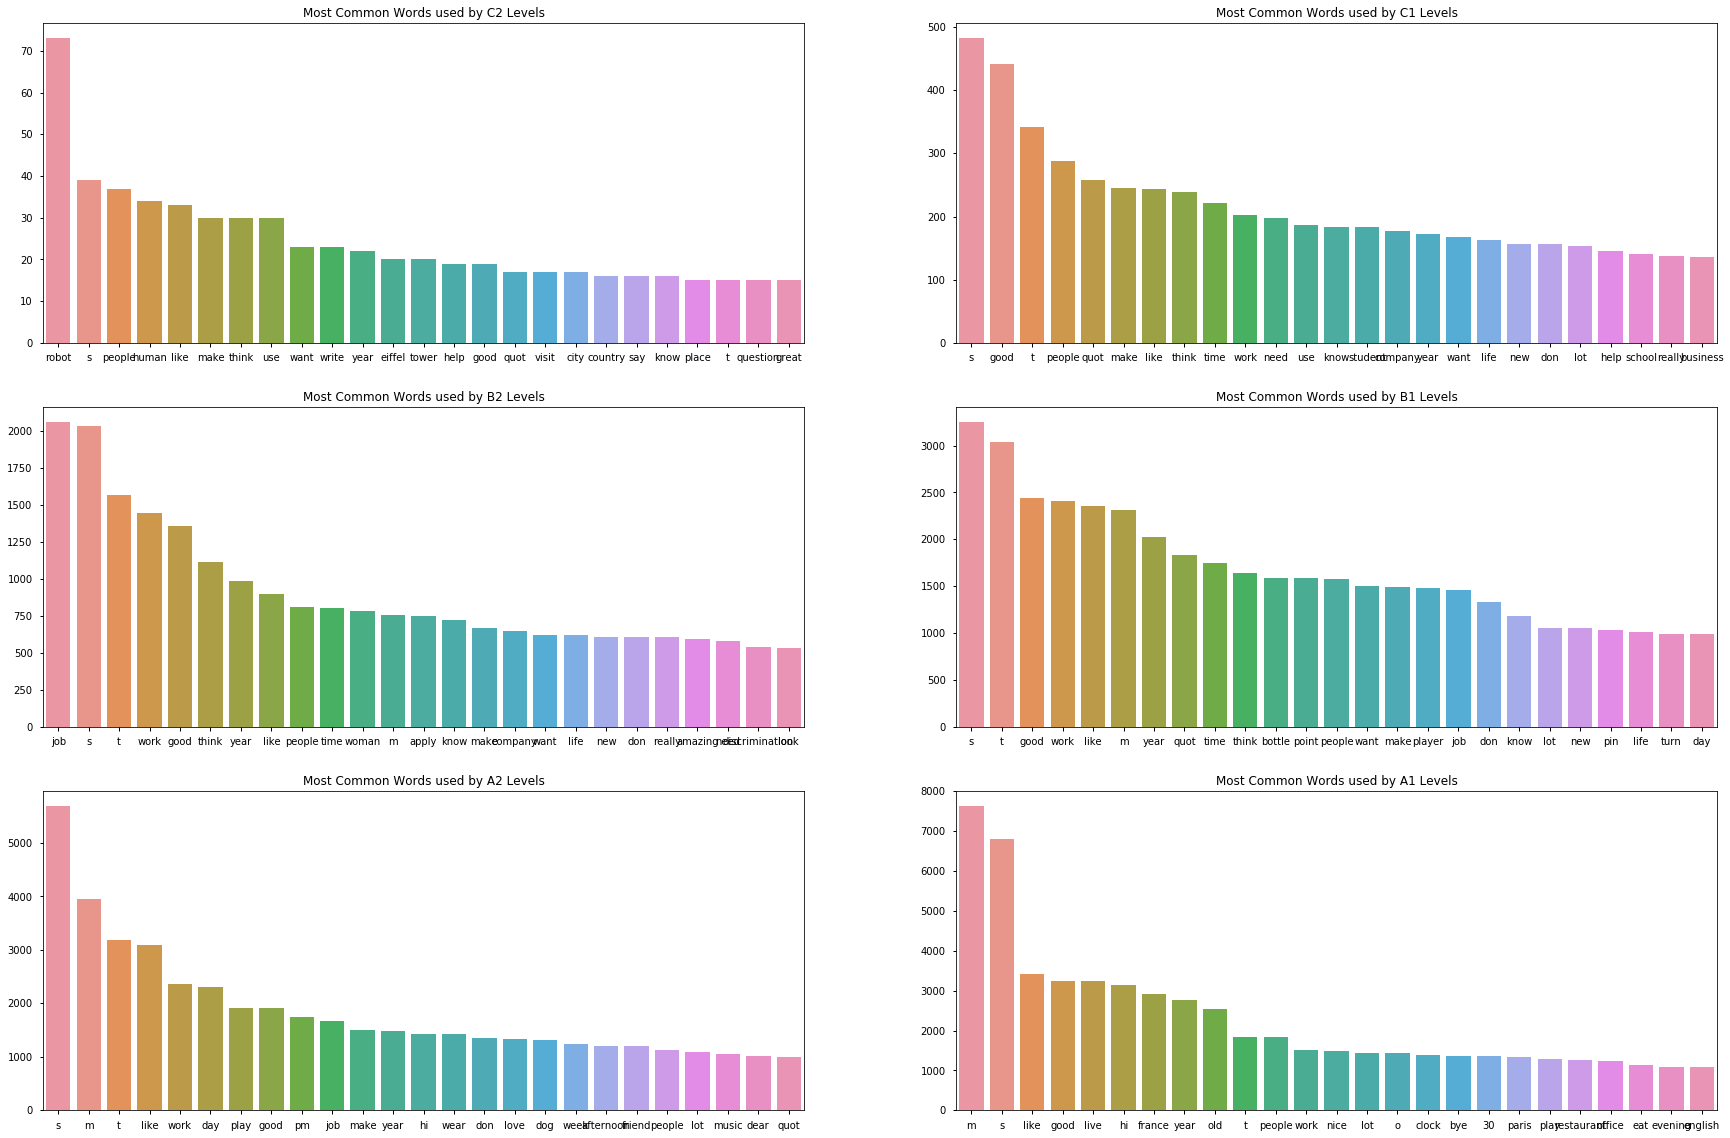

In [13]:
sns.set_context('notebook')
couples = [(c2_common_words, c2_common_count), 
           (c1_common_words, c1_common_count),
           (b2_common_words, b2_common_count),
           (b1_common_words, b1_common_count),
           (a2_common_words, a2_common_count),
           (a1_common_words, a1_common_count)]
fig=plt.figure(figsize=(30, 20))
ax1 = fig.add_subplot(321)
sns.barplot(x=c2_common_words, y=c2_common_count,ax=ax1)
plt.title('Most Common Words used by C2 Levels')
ax2 = fig.add_subplot(322)
sns.barplot(x=c1_common_words, y=c1_common_count, ax=ax2)
plt.title('Most Common Words used by C1 Levels')
ax3 = fig.add_subplot(323)
sns.barplot(x=b2_common_words, y=b2_common_count, ax=ax3)
plt.title('Most Common Words used by B2 Levels')
ax4 = fig.add_subplot(324)
sns.barplot(x=b1_common_words, y=b1_common_count, ax=ax4)
plt.title('Most Common Words used by B1 Levels')
ax5 = fig.add_subplot(325)
sns.barplot(x=a2_common_words, y=a2_common_count, ax=ax5)
plt.title('Most Common Words used by A2 Levels')
ax6 = fig.add_subplot(326)
sns.barplot(x=a1_common_words, y=a1_common_count, ax=ax6)
plt.title('Most Common Words used by A1 Levels')


plt.show()

In [14]:
#Spam..
print(data.loc[27291,:]['fulltext'])

## Compute spell check feature

Let's try to compute a new feature based on a spell checker and the assumption that level will be correlated on the number of orthographical errors in a sentence.

In [40]:
def spellratio(word, nlp):
    if word in nlp.vocab:
        return 1
    return 0

def count_spell(l, nlp):
    return float(reduce(lambda x,y:x+y, map(lambda x: spellratio(x, nlp), l))) / len(l)

data['ratio_spell'] = data["tokens_gensim"].apply(lambda l: count_spell(l, nlp))
test_data['ratio_spell'] = test_data["tokens_gensim"].apply(lambda l: count_spell(l, nlp))

In [16]:
data[['level1', 'ratio_spell']].groupby('level1').mean()

,ratio_spell
level1,
A1,0.979932
A2,0.988005
B1,0.991835
B2,0.994374
C1,0.992923
C2,0.992299


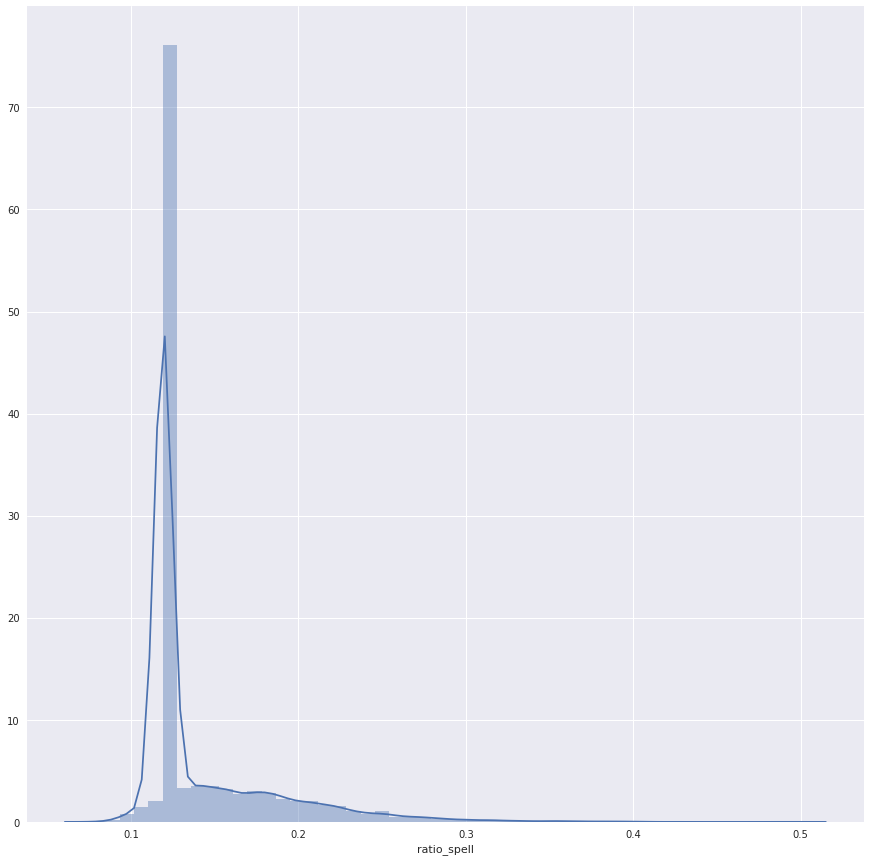

In [41]:
import numpy as np
def epsilon(ratio, epsilon):
    if ratio == 0:
        return ratio + epsilon
    elif ratio == 1 :
        return ratio - epsilon
    else:
        return ratio
    
rp = data['ratio_spell'].apply(lambda x: np.log10(1 / 1 - epsilon(x, 0.01)))
rp = rp.apply(lambda x: np.exp(x)/(np.exp(x)+1))

testrp = test_data['ratio_spell'].apply(lambda x: np.log10(1 / 1 - epsilon(x, 0.01)))
testrp = rp.apply(lambda x: np.exp(x)/(np.exp(x)+1))

sns.distplot(rp)

In [42]:
data['ratio_spell'] = rp
test_data['ratio_spell'] = testrp
data.head()

,fulltext,sentences,words,letters.all,syllables,punct,avg.sentc.length,avg.word.length,avg.syll.word,sntc.per.word,...,Root TTR,Summer,TTR.1,Uber index,Yule's K,level1,tokens_gensim,fulltext_reg,spacy_text,ratio_spell
0,\r\r\n The Eiffel Tower The Eiffel Tower ...,16,233,1116,363,32,14.562500,4.789700,1.557940,0.068670,...,8.98,0.88,0.59,24.30,146.62,C2,"[the, eiffel, tower, the, eiffel, tower, is, s...",The Eiffel Tower The Eiffel Tower is a symbol ...,eiffel tower eiffel tower symbol domination ma...,0.119203
1,\r\r\n The Court Green burglar arrested A...,7,180,866,268,18,25.714286,4.811111,1.488889,0.038889,...,8.57,0.89,0.64,26.14,141.98,C2,"[the, court, green, burglar, arrested, years, ...",The Court Green burglar arrested A 23 years ol...,court green burglar arrest 23 year old man arr...,0.119203
2,\r\r\n Thank you for giving us the opport...,10,180,861,269,20,18.000000,4.783333,1.494444,0.055556,...,9.62,0.92,0.72,35.15,62.96,C2,"[thank, you, for, giving, us, the, opportunity...",Thank you for giving us the opportunity to giv...,thank opportunity self serve celebrity piece m...,0.095737
3,\r\r\n The international AI conference ca...,10,180,872,281,20,18.000000,4.844444,1.561111,0.055556,...,9.09,0.90,0.68,30.11,70.99,C2,"[the, international, ai, conference, called, r...",The international AI conference called Robotic...,international ai conference robotics 21 st cen...,0.119203
4,\r\r\n I believe that the creative writin...,11,187,849,283,29,17.000000,4.540107,1.513369,0.058824,...,7.97,0.87,0.58,22.02,124.11,C2,"[believe, that, the, creative, writing, techni...",I believe that the creative writing techniques...,believe creative writing technique introduce u...,0.119203


In [43]:
data['MATTR'] = data['MATTR'].fillna(data.MATTR.mean())
data['MSTTR'] = data['MSTTR'].fillna(data.MSTTR.mean())

test_data['MATTR'] = test_data['MATTR'].fillna(test_data.MATTR.mean())
test_data['MSTTR'] = test_data['MSTTR'].fillna(test_data.MSTTR.mean())

## Model

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
from sklearn import model_selection, cross_validation
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import *

/home/sami/.virtualenvs/jupyter/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sami/.virtualenvs/jupyter/local/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [24]:
train_cols = data.columns.tolist()
train_cols.remove("text")
train_cols.remove("fulltext")
#train_cols.remove("MATTR")
#train_cols.remove("MSTTR")
train_cols.remove("spacy_text")
train_cols.remove("level1")
train_cols.remove("tokens_gensim")
train_cols.remove("fulltext_reg")
target = "level1"

Y = data[target].astype('str')
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
label_encoded_y = label_encoder.transform(Y)

In [25]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = cross_validation.train_test_split(data[train_cols], label_encoded_y, test_size=test_size, random_state=seed)
# fit model no training data

parameters = {'objective':'multi:softprob',
              'num_class': 6,
              'n_thread': 4,
              'n_jobs': 7,
              'learning_rate': 0.01, 
              'max_depth': 8,
              'min_child_weight': 11,
              'silent': [1],
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'n_estimators': 1000, 
              'seed': 1337}

xgtrain = xgboost.DMatrix(data[train_cols], label=label_encoded_y)
model = xgboost.XGBClassifier(**parameters)
xgb_param = model.get_xgb_params()
#do cross validation
print ('Start cross validation')
cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=15, metrics=['merror'],
     early_stopping_rounds=50, stratified=True, seed=1337)

print('Best number of trees = {}'.format(cvresult.shape[0]))
model.set_params(n_estimators=cvresult.shape[0])
print('Fit on the trainingsdata')
model.fit(data[train_cols], label_encoded_y, eval_metric='merror')

Start cross validation
Best number of trees = 1025
Fit on the trainingsdata


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=11, missing=None, n_estimators=1025,
       n_jobs=7, n_thread=4, nthread=None, num_class=6,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=[1],
       subsample=0.7)

In [26]:
print(model)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=8, min_child_weight=11, missing=None, n_estimators=1025,
       n_jobs=7, n_thread=4, nthread=None, num_class=6,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=1337, silent=[1],
       subsample=0.7)
Accuracy: 86.54%


/home/sami/.virtualenvs/jupyter/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [27]:
from sklearn.metrics import f1_score, recall_score

print 'f1 score: {}'.format(f1_score(y_test, y_pred, average=None).mean())
print 'recall score: {}'.format(recall_score(y_test, y_pred, average=None).mean())

f1 score: 0.75305794626
recall score: 0.713855570624


Our ratio spell seems to directly impact inference for the xgboost :

/home/sami/.virtualenvs/jupyter/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib


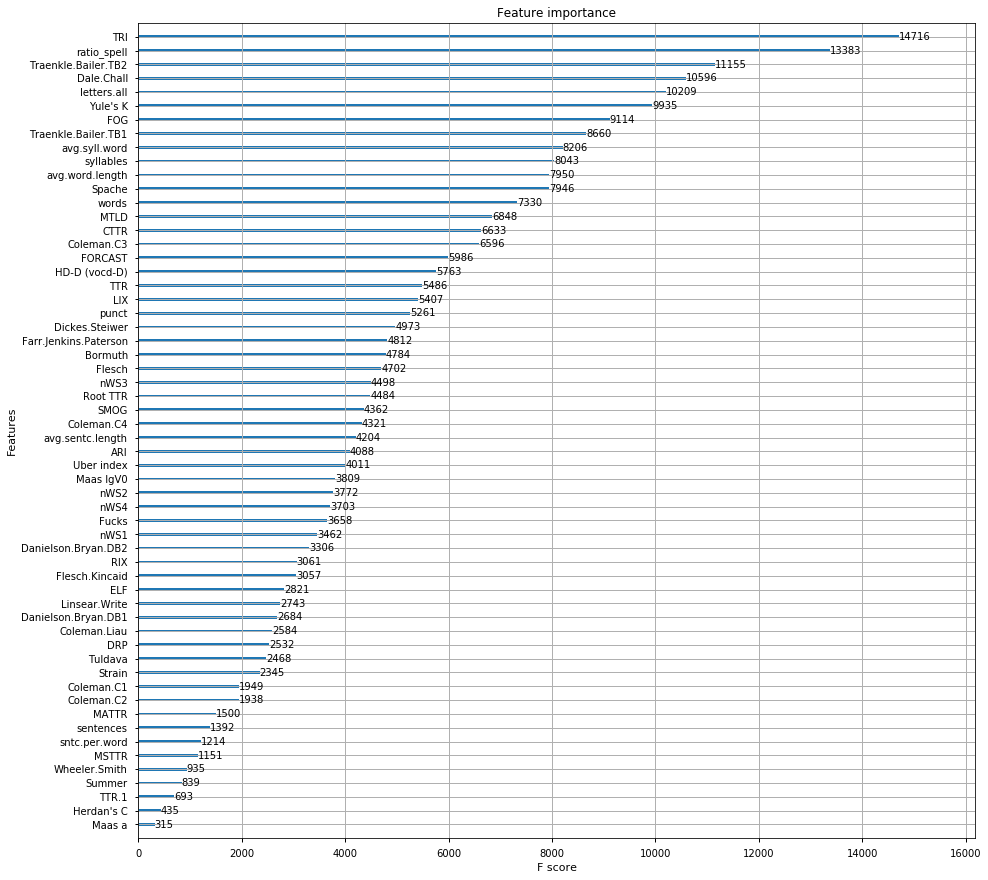

In [28]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 15)
from xgboost import plot_importance

plot_importance(model)

### Confusion Matrix

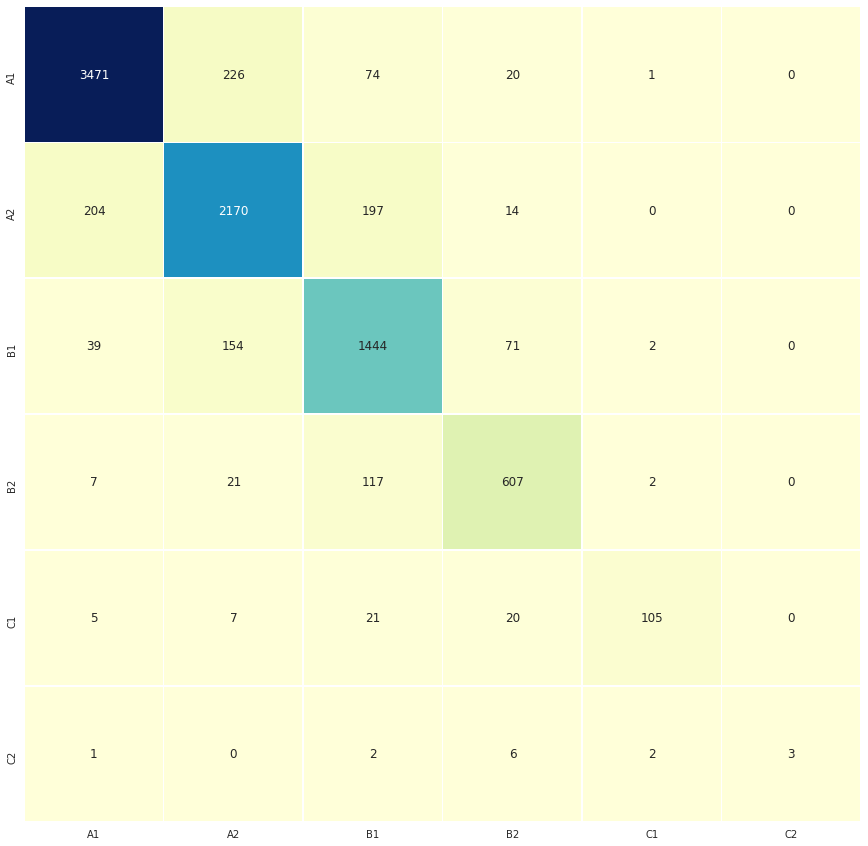

In [29]:
import seaborn as sns; sns.set()
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cnf_matrix, xticklabels=['A1','A2','B1','B2','C1','C2'], yticklabels=['A1','A2','B1','B2','C1','C2'], annot=True, cbar=False, linewidths=.5, cmap="YlGnBu", fmt='g')

In [45]:
test_cols = test_data.columns.tolist()
test_cols.remove("text")
test_cols.remove("fulltext")

test_cols.remove("spacy_text")
test_cols.remove("tokens_gensim")
test_cols.remove("fulltext_reg")

y_pred = model.predict(test_data[test_cols])
predictions = [round(value) for value in y_pred]

/home/sami/.virtualenvs/jupyter/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [48]:
predictions = [int(x) for x in predictions]
labels = label_encoder.inverse_transform(predictions)

test_pred = test_data.copy()

test_pred['prediction'] = labels
test_pred.head()

/home/sami/.virtualenvs/jupyter/local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,fulltext,sentences,words,letters.all,syllables,punct,avg.sentc.length,avg.word.length,avg.syll.word,sntc.per.word,...,Root TTR,Summer,TTR.1,Uber index,Yule's K,tokens_gensim,fulltext_reg,spacy_text,ratio_spell,prediction
0,"\r\r\n On Saturday at 11:30, he goes swim...",1,39,142,51,6,39.000000,3.641026,1.307692,0.025641,...,5.12,0.88,0.82,29.47,105.19,"[on, saturday, at, he, goes, swimming, at, he,...","On Saturday at 11 30, he goes swimming At 12 3...",saturday 11 30 swim 12 30 eat lunch afternoon ...,0.529765,A1
1,"\r\r\n Last year, I went to Singapore, Ba...",7,42,182,65,10,6.000000,4.333333,1.547619,0.166667,...,4.78,0.83,0.74,19.98,260.77,"[last, year, went, to, singapore, bali, island...",Last year I went to Singapore Bali Island and ...,year singapore bali island lombok island indon...,0.529765,A1
2,\r\r\n To xxx@outlook.com xxx@yahoo.fr Fr...,9,86,299,95,16,9.555556,3.476744,1.104651,0.104651,...,5.72,0.83,0.62,17.80,164.95,"[to, xxx, outlook, com, xxx, yahoo, fr, from, ...",To xxx outlook com xxx yahoo fr From xxx wanad...,xxx outlook com xxx yahoo fr xxx wanadoo fr su...,0.523916,A2
3,\r\r\n Dear Mum Our dream both is to see ...,8,122,520,169,18,15.250000,4.262295,1.385246,0.065574,...,6.97,0.86,0.63,21.78,122.28,"[dear, mum, our, dream, both, is, to, see, the...",Dear Mum Our dream both is to see the world th...,dear mum dream world year return change job sc...,0.529765,A1
4,"\r\r\n HI, I am planning a party for my b...",6,79,253,91,16,13.166667,3.202532,1.151899,0.075949,...,5.96,0.85,0.67,20.77,189.07,"[hi, am, planning, party, for, my, birthday, o...",HI I am planning a party for my birthday on sa...,hi plan party birthday saturday 20 th june hop...,0.529765,A2
